In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

C:\Users\snuist\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
sess = tf.Session()

In [3]:
save_file_name = os.path.join('temp','temp_spam_data.csv')

# Create a directory if it doesn't exist
if not os.path.exists('temp'):     # 만약 해당 파일이 path에 존재하지 않으면 
    os.makedirs('temp')            # directory를 만든다

if os.path.isfile(save_file_name): # 만약 file이면서 save_file_name이 있다면,  
    text_data = []
    with open(save_file_name, 'r') as temp_output_file: # 파일을 읽기모드(r)로 열어서
        reader = csv.reader(temp_output_file)           # csv reader로 연다.
        for row in reader:
            text_data.append(row)

else: 
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()   # binary로 encoding된 파일을 decode
    text_data = text_data.encode('ascii',errors='ignore') # encoding을 ascii code로 바꾸기
    text_data = text_data.decode().split('\n') # 줄바꿈 되어 있는 부분을 기준으로 text data를 나누기
    text_data = [x.split('\t') for x in text_data if len(x)>=1]  # text_data에서 빈 부분을 뺀 나머지를 tab 기준으로  split
    
    # write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]   # message
target = [x[0] for x in text_data]  # ham/spam

In [4]:
text_data

[['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
 ['ham', 'Ok lar... Joking wif u oni...'],
 ['spam',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
 ['ham', 'U dun say so early hor... U c already then say...'],
 ['ham', "Nah I don't think he goes to usf, he lives around here though"],
 ['spam',
  "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, 1.50 to rcv"],
 ['ham',
  'Even my brother is not like to speak with me. They treat me like aids patent.'],
 ['ham',
  "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"],
 ['spam',
  'WINNER!! As a valued network customer you have been selected to receivea 90

In [5]:
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if  x=='spam' else 0 for x in target]

# Normalize text
# lower case
texts = [x.lower() for x in texts]

# Remove punctuation (string.punctuation에 없는 단어의 경우 빈칸 없이 join)
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join( c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

적절한 문장 길이를 알고 나머지 데이터는 잘라내기 위해 histogram을 사용 (chracter 갯수가 아니라 단어 기준)

In [14]:
print(texts[0])
print(len(texts[0]))

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
102


In [15]:
print(texts[0].split())
print(len(texts[0].split()))

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
20


(array([1.206e+03, 1.872e+03, 1.004e+03, 9.520e+02, 3.760e+02, 7.400e+01,
        2.000e+01, 1.700e+01, 1.900e+01, 1.400e+01, 6.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00]),
 array([  0.  ,   6.84,  13.68,  20.52,  27.36,  34.2 ,  41.04,  47.88,
         54.72,  61.56,  68.4 ,  75.24,  82.08,  88.92,  95.76, 102.6 ,
        109.44, 116.28, 123.12, 129.96, 136.8 , 143.64, 150.48, 157.32,
        164.16, 171.  ]),
 <a list of 25 Patch objects>)

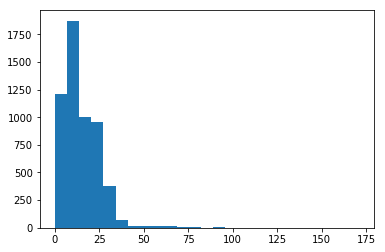

In [18]:
%matplotlib inline
# plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
plt.hist(text_lengths, bins=25)

Trim down the text lengths from the length of 50


Text(0.5,1,'Histogram of # of Words in Texts')

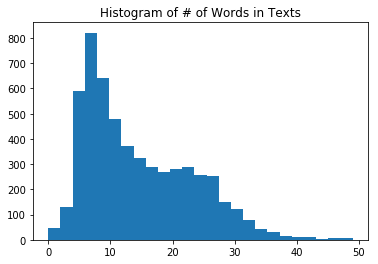

In [24]:
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title("Histogram of # of Words in Texts")

우리는 모든 텍스트가 길이 25정도이길 원함. 짧은 것들은 padding, 긴 것들은 crop을 해준다.

In [25]:
# Hyperparameters
sentence_size = 25
min_word_freq = 3

In [31]:
# Setup Vocabulary Processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# Have to fit transform to get lengths of unique words
vocab_processor.transform(texts)
embedding_size = len([x for x in vocab_processor.transform(texts)]) 
# list로 바꿔야 len를 계산할 수 있어서 저렇게 바꾸고 length를 취해준 것임
# embedding_size는 sentence 갯수임

In [43]:
m = []
for i in vocab_processor.transform(texts):
    m.append(i)
len(m)

5574

In [48]:
m[-2]

array([ 141, 2552,  224,   79, 8164,  364,   56, 7383,   78,   77,  149,
       1510,    8,  807,  571,  672,  210,  180,   73,   59,  688,   84,
         32,  887,   83], dtype=int64)

## Testing logistic model
### 우선 문장의 벡터들을 구하기 위해 그것들에 one-hot encoding실시할 것임

In [33]:
# Split the data into train(80%)/test(20%)
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=True)
test_indices = np.array(list(set(range(len(texts)))-set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [55]:
texts_test[0]

'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune'

For one hot encoding, we setup an identity matrix for the TensorFlow embedding lookup. 

In [34]:
# Setup index matrix for one hot encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1], dtype=tf.float32)

## 질문
#### x_data는 길이 25의 문장에 있는 단어 index에 해당하는 one_hot 벡터를 떼어오는 것인데(각 문장별 dimension = (sentence_size, embedding_size)), 고유한 단어의 갯수는 8164를 넘는다. 그럼 이렇게 5564를 넘는 단어들은 embedding vector를 배정받지 못하는 것 아닌가?

## 정리
#### 개개 벡터들을 인덱스로 떼어와서 sentence별로 sum을 하면 [1,1,0,0,1,0]과 같이 문장에 등장하는 단어들이 표시되어 있는 형태가 되고 dimension은 sentence size가 1이 되면서 shape= (1,embedding_size)가 됨. 이것이 문장들별로 한 개씩 생기게 됨. 근데 어쨌든 x_data가 문장 각각이므로 여기서 concatenate는 생각하지 않는 것이 좋음. expand_dims를 한 이유는 원래 (embedding_size,) 이렇게 나오니까 (_,어쩌구)가 되도록 하는 것임 -> 그 결과 (1, embedding_size)가 됨

In [44]:
# Text-vocab embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
'''x_embed를 통해서 identity matrix에 있는 것들로부터 x_data(길이 25로 normalize된 
    문장들) 각각에 one-hot vector 부여'''
x_col_sums = tf.reduce_sum(x_embed,0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [50]:
# Loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction
prediction = tf.sigmoid(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Initialize variables 
init = tf.global_variables_initializer()
sess.run(init)

In [52]:
# Start Logistic Regresssion
print("Starting Training over {} Sentences.".format(len(texts_train)))

loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ':Loss = ' + str(temp_loss))
        
    # keep training average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix] == np.round(temp_pred) # 아까 시그모이드에 넣어서 얻은 0과 1사이의 값을 반올림
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:])) # 최근 50개의 평균

Starting Training over 3061 Sentences.
Training Observation #10:Loss = 2.3971374
Training Observation #20:Loss = 1.5903543e-05
Training Observation #30:Loss = 2.4359865
Training Observation #40:Loss = 0.00045630345
Training Observation #50:Loss = 0.7476783
Training Observation #60:Loss = 0.009044526
Training Observation #70:Loss = 0.17637584
Training Observation #80:Loss = 0.01775764
Training Observation #90:Loss = 2.2634122
Training Observation #100:Loss = 2.6380033
Training Observation #110:Loss = 3.0233417
Training Observation #120:Loss = 0.001047516
Training Observation #130:Loss = 0.0011390068
Training Observation #140:Loss = 0.0032343895
Training Observation #150:Loss = 1.7168221
Training Observation #160:Loss = 0.76110953
Training Observation #170:Loss = 0.00023933165
Training Observation #180:Loss = 0.19480523
Training Observation #190:Loss = 3.8756077
Training Observation #200:Loss = 6.1187387
Training Observation #210:Loss = 11.585276
Training Observation #220:Loss = 0.051198

Training Observation #1840:Loss = 2.5917828
Training Observation #1850:Loss = 3.6124792
Training Observation #1860:Loss = 5.20011
Training Observation #1870:Loss = 5.2886457
Training Observation #1880:Loss = 0.22583199
Training Observation #1890:Loss = 7.734968e-05
Training Observation #1900:Loss = 0.008690515
Training Observation #1910:Loss = 8.644277e-05
Training Observation #1920:Loss = 0.00020814828
Training Observation #1930:Loss = 0.0027662616
Training Observation #1940:Loss = 3.5058215
Training Observation #1950:Loss = 0.003836067
Training Observation #1960:Loss = 0.0003202094
Training Observation #1970:Loss = 0.0037986017
Training Observation #1980:Loss = 0.00055386184
Training Observation #1990:Loss = 0.0255311
Training Observation #2000:Loss = 0.0031882108
Training Observation #2010:Loss = 0.00922854
Training Observation #2020:Loss = 9.627279
Training Observation #2030:Loss = 0.00052742974
Training Observation #2040:Loss = 0.00061833044
Training Observation #2050:Loss = 0.001

In [56]:
# Get test set accuracy
print("Getting test set accruacy for {} sentences.".format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)% 50 ==0:
        print("Test observation #" + str(ix+1))
    
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print("\nOverall Test Accuracy: {}".format(np.mean(test_acc_all)))

Getting test set accruacy for 2513 sentences.
Test observation #50
Test observation #100
Test observation #150
Test observation #200
Test observation #250
Test observation #300
Test observation #350
Test observation #400
Test observation #450
Test observation #500
Test observation #550
Test observation #600
Test observation #650
Test observation #700
Test observation #750
Test observation #800
Test observation #850
Test observation #900
Test observation #950
Test observation #1000
Test observation #1050
Test observation #1100
Test observation #1150
Test observation #1200
Test observation #1250
Test observation #1300
Test observation #1350
Test observation #1400
Test observation #1450
Test observation #1500
Test observation #1550
Test observation #1600
Test observation #1650
Test observation #1700
Test observation #1750
Test observation #1800
Test observation #1850
Test observation #1900
Test observation #1950
Test observation #2000
Test observation #2050
Test observation #2100
Test obs

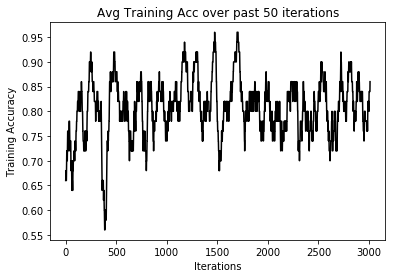

In [57]:
%matplotlib inline
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-',label='Train Accuracy')
plt.title('Avg Training Acc over past 50 iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()